## 장마 시작 ~ 끝 예측 하기
* 이것도 실제로 예측하는건 불가능해요.
* 기상청도 틀리는데 어떻게 예측하겠어요.
* 장마가 발생하기 위한 조건이나 날짜 이외의 기상정보가 포함되지 않았기 때문에 실제 예측은 안돼요.
* 하지만 이것도 시계열은 이렇게 하는거다를 위한 실습이니까 진행해주세요.

In [1]:
# 사용 모듈 import 할게요.
import numpy as np
import pandas as pd
from pprint import pprint
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [2]:
# 장마.csv파일 열어 보시면 1~3번 줄이 기온처럼 메타 데이터로 되어있어서
# list slicing으로 넘겨버릴게요.
# 파일 읽고 확인해볼게요
data_path = '../data/'
lines = open(data_path+'장마.csv', 'r').readlines()[3:-1]
print(lines[0])
print(lines[-1])

295,남해,1990-06-19,1990-07-19,31,19,523

295,남해,2019-06-26,2019-07-28,33,17,784.9



In [3]:
# 데이터 정리하고 확인 진행할게요.
data = []
years_for_index = []

for line in lines:
    _, _, start_date, end_date, _, _, _ = line.strip().split(',')
    start_year, start_month, start_day = start_date.strip().split('-')
    end_year, end_month, end_day = end_date.strip().split('-')
    years_for_index.append(np.int(start_year))
    data.append([np.float(start_month), np.float(start_day),
                 np.float(end_month), np.float(end_day)])

# 앞쪽부터 [시작월, 시작일, 종료월, 종료일]이에요.
pprint(data[:5])

[[6.0, 19.0, 7.0, 19.0],
 [6.0, 26.0, 8.0, 2.0],
 [7.0, 9.0, 7.0, 23.0],
 [6.0, 22.0, 7.0, 30.0],
 [6.0, 22.0, 7.0, 6.0]]


In [4]:
# 정리한 데이터로 DataFrame 생성하고
# 컬럼이랑 인덱스 설정한 다음
# 확인해볼게요.
df = pd.DataFrame(data)
df.columns = ['Start_Month', 'Start_Day', 'End_Month', 'End_Day']
df.index = years_for_index
df

,Start_Month,Start_Day,End_Month,End_Day
1990,6.0,19.0,7.0,19.0
1991,6.0,26.0,8.0,2.0
1992,7.0,9.0,7.0,23.0
1993,6.0,22.0,7.0,30.0
1994,6.0,22.0,7.0,6.0
1995,6.0,30.0,7.0,27.0
1996,6.0,24.0,7.0,22.0
1997,6.0,20.0,7.0,18.0
1998,6.0,24.0,7.0,28.0
1999,6.0,17.0,7.0,20.0


In [5]:
# 학습데이터랑 평가데이터 나눌게요.
# 기온이랑 비슷하게 1990년~2018년을 학습에 사용하고
# 2019년을 평가에 사용할게요
train_dataset = df[df.index < 2019].dropna().values
test_dataset = df[df.index == 2019].dropna().values

# 어떻게 나눠졌는지 확인할게요.
print(train_dataset[:5])
print(test_dataset)

[[ 6. 19.  7. 19.]
 [ 6. 26.  8.  2.]
 [ 7.  9.  7. 23.]
 [ 6. 22.  7. 30.]
 [ 6. 22.  7.  6.]]
[[ 6. 26.  7. 28.]]


In [6]:
# 데이터를 입력이랑 타겟으로 나누는 함수 작성할게요.
def div_xy(data, seek_step, features):
    x, y = [], []
    for i in range(len(data)-seek_step-1):
        x.append(data[i:i+seek_step])
        y.append(data[i+seek_step])
    return np.array(x, dtype=np.float).reshape(-1, seek_step, features), np.array(y, dtype=np.float).reshape(-1, features)

In [7]:
# 기온이랑 동일하게 5일전을 볼거고,
# features는 시작월, 시작일, 종료월, 종료일 로 총 4개니까
# 4로 설정할게요.
seek_step = 5
features = 4

In [8]:
# 작성한 함수로 데이터 입력이랑 타켓으로 나누고 확인할게요.
x_train, y_train = div_xy(train_dataset, seek_step, features)

# shape 확인해주세요.
print(x_train.shape)
print(y_train.shape)

for i in range(5):
    print(x_train[i], end=' : ')
    print(y_train[i])

(23, 5, 4)
(23, 4)
[[ 6. 19.  7. 19.]
 [ 6. 26.  8.  2.]
 [ 7.  9.  7. 23.]
 [ 6. 22.  7. 30.]
 [ 6. 22.  7.  6.]] : [ 6. 30.  7. 27.]
[[ 6. 26.  8.  2.]
 [ 7.  9.  7. 23.]
 [ 6. 22.  7. 30.]
 [ 6. 22.  7.  6.]
 [ 6. 30.  7. 27.]] : [ 6. 24.  7. 22.]
[[ 7.  9.  7. 23.]
 [ 6. 22.  7. 30.]
 [ 6. 22.  7.  6.]
 [ 6. 30.  7. 27.]
 [ 6. 24.  7. 22.]] : [ 6. 20.  7. 18.]
[[ 6. 22.  7. 30.]
 [ 6. 22.  7.  6.]
 [ 6. 30.  7. 27.]
 [ 6. 24.  7. 22.]
 [ 6. 20.  7. 18.]] : [ 6. 24.  7. 28.]
[[ 6. 22.  7.  6.]
 [ 6. 30.  7. 27.]
 [ 6. 24.  7. 22.]
 [ 6. 20.  7. 18.]
 [ 6. 24.  7. 28.]] : [ 6. 17.  7. 20.]


In [9]:
# 모델 Loss 확인용 클래스 작성할게요.
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [10]:
# 모델 생성 및 컴파일 진행할게요.
history = LossHistory()
history.init()

model = Sequential()
model.add(SimpleRNN(units=256, batch_input_shape=(1,5,4)))
model.add(Dense(4))
model.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy'])

In [11]:
# 장마 시작 및 끝 일자 모델에 학습 진행할게요.
model.fit(x_train, y_train, epochs=100, batch_size=1, callbacks=[history])

Epoch 1/100
23/23 [==============================] - 0s 1ms/step - loss: 88.0763 - accuracy: 0.4783 
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 33.9984 - accuracy: 0.4348
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 25.2457 - accuracy: 0.6087
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 23.5017 - accuracy: 0.5217
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 23.0795 - accuracy: 0.4783
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 22.5154 - accuracy: 0.6957
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 22.5668 - accuracy: 0.3478
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 22.3597 - accuracy: 0.5652
Epoch 9/100
23/23 [==============================] - ETA: 0s - loss: 6.3322 - accuracy: 1.00 - 0s 1ms/step - loss: 22.2552 - accuracy: 0.4783
Epoch 10/100
23/23 [==============================] - 0s 

23/23 [==============================] - 0s 1ms/step - loss: 1.4322 - accuracy: 0.9130
Epoch 82/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6083 - accuracy: 0.9565
Epoch 83/100
23/23 [==============================] - 0s 1ms/step - loss: 1.0267 - accuracy: 0.9565
Epoch 84/100
23/23 [==============================] - 0s 1ms/step - loss: 1.5839 - accuracy: 0.7826
Epoch 85/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5679 - accuracy: 0.9565
Epoch 86/100
23/23 [==============================] - 0s 1ms/step - loss: 0.6928 - accuracy: 0.9130
Epoch 87/100
23/23 [==============================] - 0s 1ms/step - loss: 0.8196 - accuracy: 0.8696
Epoch 88/100
23/23 [==============================] - 0s 1ms/step - loss: 1.6866 - accuracy: 0.8696
Epoch 89/100
23/23 [==============================] - 0s 1ms/step - loss: 0.5973 - accuracy: 0.8696
Epoch 90/100
23/23 [==============================] - 0s 1ms/step - loss: 1.1125 - accuracy: 0.9130
Epoch 91/100


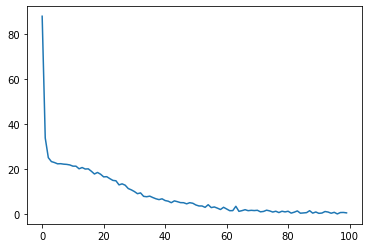

In [12]:
# Loss plot으로 확인할게요.
loss = history.losses
epochs = range(len(loss))
plt.plot(epochs, loss)
plt.show()

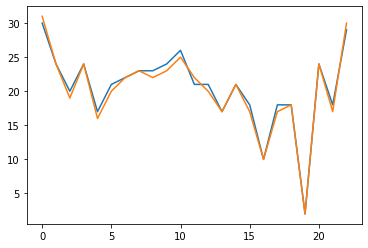

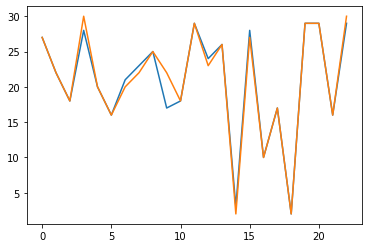

In [13]:
# 학습 데이터로 모델 확인해볼게요.
y_hat = []
for trained_x in x_train:
    trained_x = trained_x.reshape(1, seek_step, features)
    y_hat.append(model.predict(trained_x))
length = range(len(y_hat))
plt.plot(length, y_train[:, 1], np.ceil(np.squeeze(y_hat)[:, 1]))
plt.show()
plt.plot(length, y_train[:, 3], np.ceil(np.squeeze(y_hat)[:, 3]))
plt.show()

In [14]:
# 최근 2014~2018년 데이터 입력해서 2019년 일자 확인해볼게요.
test_x = np.concatenate((np.squeeze(x_train[-1, -4:]), [y_train[-1]]), axis=0)
print(test_x)

y_test_hat = model.predict(test_x.reshape(1, seek_step, features))
print(test_dataset)

# float이 결과로 나오기 때문에, 
print(np.round(y_test_hat)) # 반올림
print(np.ceil(y_test_hat))  # 올림
print(np.trunc(y_test_hat)) # 버림
# 을 사용해 적절한 일자를 확인하는 수 말고는 없어요...

[[ 6. 18.  8.  2.]
 [ 7.  2.  7. 29.]
 [ 6. 24.  7. 29.]
 [ 6. 18.  7. 16.]
 [ 6. 29.  7. 29.]]
[[ 6. 26.  7. 28.]]
[[ 6. 23.  7. 19.]]
[[ 7. 23.  7. 20.]]
[[ 6. 22.  6. 19.]]


In [15]:
# 최근 5년간(2015~2019)의 데이터로 올해 장마 일자 확인해볼게요.
test_x = np.concatenate((np.squeeze(test_x[-4:]), test_dataset), axis=0)
print(test_x)

y_predict = model.predict(test_x.reshape(1, seek_step, features))
print(np.round(y_predict))
print(np.ceil(y_predict))
print(np.trunc(y_predict))
# 바보같네요. 학습 한번더 진행할게요. 
# model.fit() 작성된 셀부터 이 셀까지 다시 실행할게요.

# 적당히 하고 넘어가도록 하죠...
# 이제 강수일수 데이터로 직접 해보시도록 할게요.
# 코드는 거의 비슷하니까 참고하면서 진행해주세요.

[[ 7.  2.  7. 29.]
 [ 6. 24.  7. 29.]
 [ 6. 18.  7. 16.]
 [ 6. 29.  7. 29.]
 [ 6. 26.  7. 28.]]
[[ 6. 22.  7. 19.]]
[[ 6. 23.  7. 20.]]
[[ 5. 22.  6. 19.]]
